Load the dataset and define some labels for groups of different columns

In [25]:
import pandas as pd
import os

path = os.path.join('..','results','dataset_with_noNA.csv')
wide_standardized_noNA = pd.read_csv(path)
wide_standardized_noNA['Day'] = pd.to_datetime(wide_standardized_noNA['Day'])

variables = wide_standardized_noNA.columns.tolist()
trN_variables = [var for var in variables if var.startswith('TR') and var.endswith('N')]
pot_variables = [var for var in variables if 'Pot_att' in var]
cosfi = [var for var in variables if var.endswith('cosFi')]

wide_standardized_noNA

,Day,PERD_GR,TR1_Corr_N,TR1_Pot_att,TR1_cosFi,TR2_Corr_N,TR2_Pot_att,TR2_cosFi,TR3_Corr_N,TR3_Pot_att,TR3_cosFi
0,2022-01-06,0.507029,-1.600095,-1.292598,0.646569,-2.449617,-2.390089,-2.485613,2.370580,2.563919,2.498133
1,2022-01-07,0.462060,-1.696996,-1.760198,0.603159,-2.449617,-2.390089,-2.485613,2.387237,2.478809,2.485275
2,2022-01-08,0.446937,-1.600095,-1.978692,0.666575,-2.449617,-2.390089,-2.485613,2.341381,2.468522,2.489890
3,2022-01-09,0.351997,-1.803588,-2.212015,0.394216,-2.449617,-2.390089,-2.485613,2.334326,2.417645,2.489911
4,2022-01-10,0.179581,-1.498349,-1.863998,0.144100,-2.449617,-2.390089,-2.485613,2.489532,2.474847,2.468301
...,...,...,...,...,...,...,...,...,...,...,...
543,2023-07-03,-1.110777,3.777928,-0.040692,0.440832,0.814704,1.140090,0.462033,-0.401177,-0.402055,-0.402153
544,2023-07-04,-0.267124,2.629648,0.285839,0.448404,0.668427,0.953332,0.461576,-0.401177,-0.402055,-0.402153
545,2023-07-05,-0.438423,2.581197,-0.458917,0.357539,0.867000,1.172150,0.457968,-0.401177,-0.402055,-0.402153
546,2023-07-06,-2.541227,1.680015,-0.254949,0.182434,0.740429,1.007057,0.436132,-0.401177,-0.402055,-0.402153


Cluster days together using K-Means

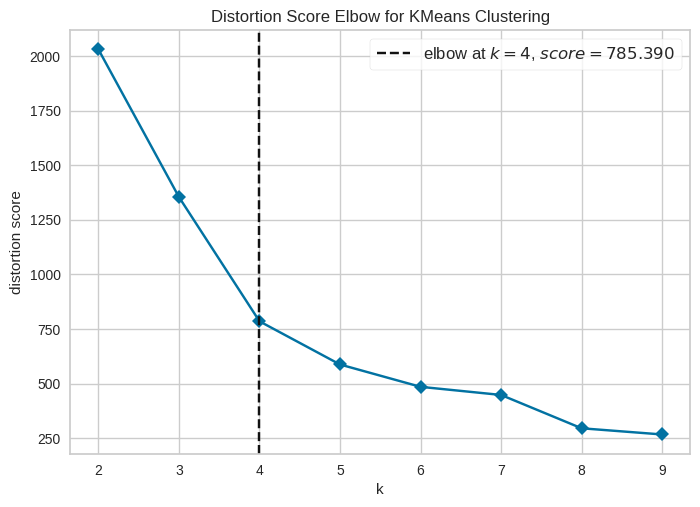

In [4]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
import seaborn as sns

# Removing the 'Day' column as it's not relevant for clustering
data_clustering = wide_standardized_noNA.drop('Day', axis=1)

# Using the Elbow Method to find the optimal number of clusters
wcss = []  # Within-Cluster Sum of Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init = 'auto', random_state=123)
    kmeans.fit(data_clustering)
    wcss.append(kmeans.inertia_)

kmeans = KMeans(init='k-means++', n_init='auto', random_state=123)
visualizer = KElbowVisualizer(kmeans, k=(2,10), timings=False)
visualizer.fit(data_clustering)
visualizer.show()
plt.show()

Cluster days together using DBSCAN

In [11]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from itertools import product
import numpy as np

# DBSCAN clustering
# We need to specify the epsilon (eps) and minimum samples (min_samples) parameters
# We will seek optimal ones by grid hyperparameter tuning

eps_values = np.arange(4,9,0.25) # eps values to be investigated
min_samples = np.arange(2,10) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(data_clustering)
    sil_score.append(silhouette_score(data_clustering, DBS_clustering.labels_))

tmp = pd.DataFrame.from_records(DBSCAN_params, columns = ['Eps', 'Min. samples'])   
tmp['Silhouette score'] = sil_score

dbscan_tuning = tmp.pivot(index='Eps', columns='Min. samples', values='Silhouette score')
dbscan_tuning

Min. samples,2,3,4,5,6,7,8,9
Eps,,,,,,,,
4.00,0.801339,0.796972,0.796972,0.796972,0.796972,0.796972,0.796972,0.796972
4.25,0.801339,0.796972,0.796972,0.796972,0.796972,0.796972,0.796972,0.796972
4.50,0.802312,0.797752,0.797752,0.797752,0.797752,0.797752,0.797752,0.797752
4.75,0.802312,0.797752,0.797752,0.797752,0.797752,0.797752,0.797752,0.797752
5.00,0.802312,0.797752,0.797752,0.797752,0.797752,0.797752,0.797752,0.797752
5.25,0.802312,0.797752,0.797752,0.797752,0.797752,0.797752,0.797752,0.797752
5.50,0.723542,0.784130,0.784130,0.784130,0.784130,0.784130,0.784130,0.784130
5.75,0.723542,0.784130,0.784130,0.784130,0.784130,0.784130,0.784130,0.784130
6.00,0.723542,0.784130,0.784130,0.784130,0.784130,0.784130,0.784130,0.784130


Pairs plots

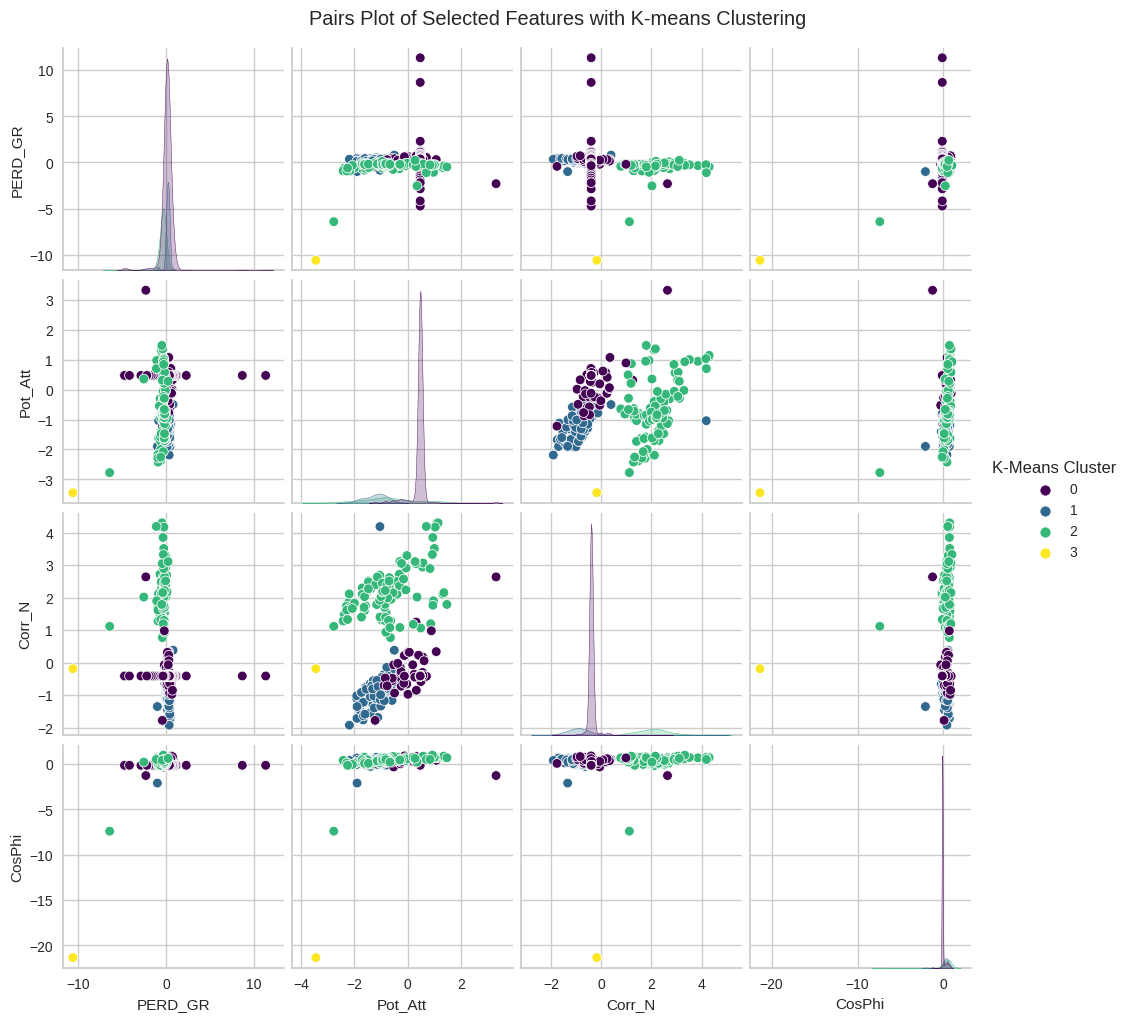

In [7]:
plotting_df = wide_standardized_noNA.copy()

plotting_df['Pot_Att'] = plotting_df[pot_variables].sum(axis=1)
plotting_df['Corr_N'] = plotting_df[trN_variables].sum(axis=1)
plotting_df['CosPhi'] = plotting_df[cosfi].sum(axis=1)
plotting_df.drop(pot_variables+trN_variables+cosfi, axis=1, inplace=True)

kmeans_max_asw = KMeans(n_clusters=4, init='k-means++', n_init = 'auto', random_state=123)
plotting_df['K-Means Cluster'] = kmeans_max_asw.fit_predict(data_clustering)

sns.pairplot(plotting_df, hue='K-Means Cluster', palette='viridis')
plt.suptitle('Pairs Plot of Selected Features with K-means Clustering', y=1.02)
plt.show()

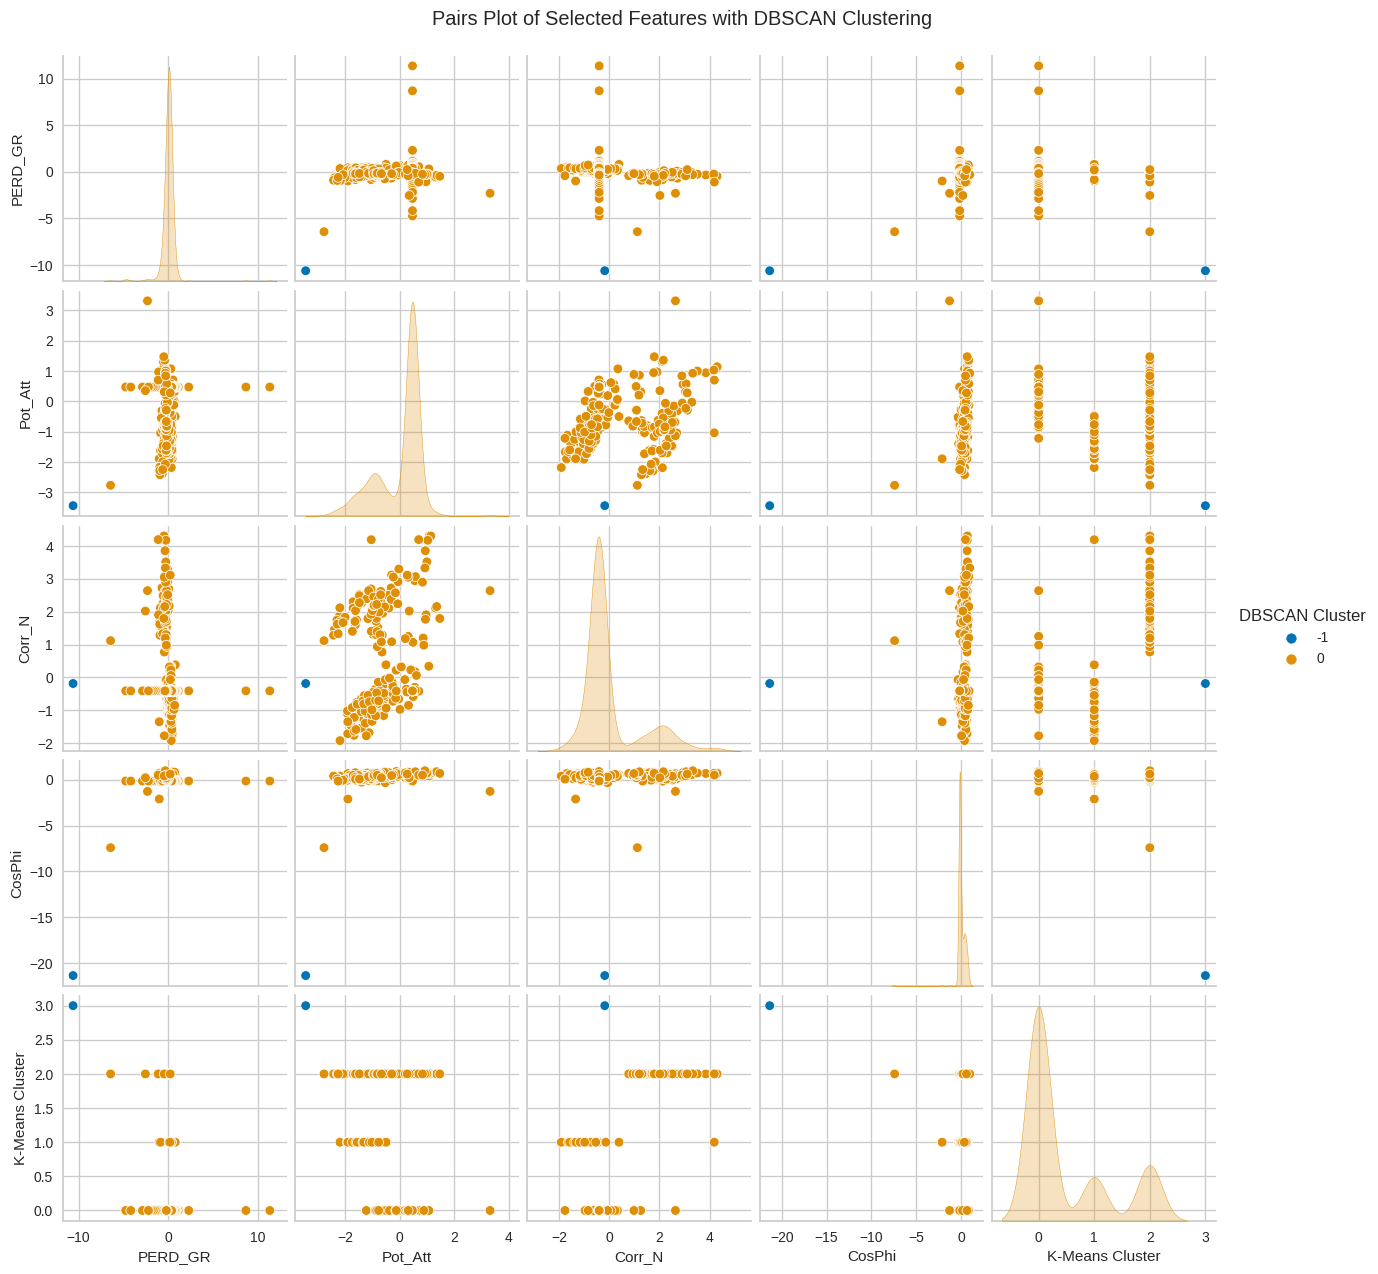

In [14]:
dbscan = DBSCAN(eps=8.5)
plotting_df['DBSCAN Cluster'] = dbscan.fit_predict(data_clustering)

sns.pairplot(plotting_df, hue='DBSCAN Cluster', palette='colorblind')
plt.suptitle('Pairs Plot of Selected Features with DBSCAN Clustering', y=1.02)
plt.show()

Plot dates on the x-axis and cluster groups on the y-axis

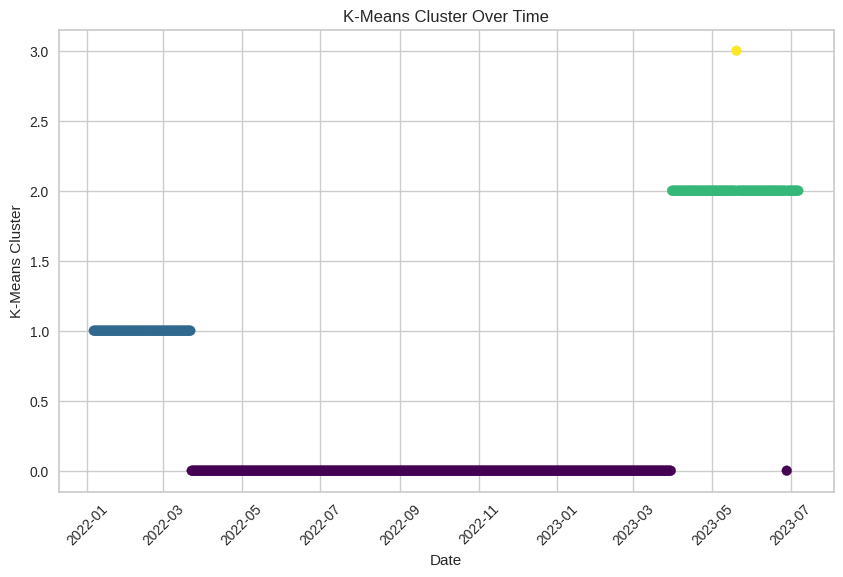

In [26]:
plotting_df['Day'] = pd.to_datetime(plotting_df['Day'])

plt.figure(figsize=(10, 6))
plt.scatter(plotting_df['Day'], plotting_df['K-Means Cluster'], c=plotting_df['K-Means Cluster'], cmap='viridis')
plt.title('K-Means Cluster Over Time')
plt.xlabel('Date')
plt.ylabel('K-Means Cluster')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()